In [1]:
%reset -f

from functions import *
from preprocess_images import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir

from PIL import  Image

from sklearn import cluster, metrics

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [134]:
from tqdm import tqdm

from keras_preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

from keras.models import Sequential
from keras.layers import Dense
from keras.models import Model

from keras.optimizers import SGD

In [197]:
from sklearn import manifold, decomposition

In [2]:
# Starting time
t0 = time()

input_path = "./dataset/cleaned/"
path_images = "./dataset/images/"
input_filename = "data_images.csv"
input_file = "{}{}".format(input_path, input_filename)

output_path = "./dataset/cleaned/"

In [3]:
list_photos = [file for file in listdir(path_images)]
print(len(list_photos))

1050


In [4]:
data_images = pd.read_csv(input_file)
data_images.head()

,image_path,category,target
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4


# PART 1 :

In [5]:
print("TEST")
#img = Image.open(path_images + "0906fd9cc604fbba05a502e01d763cd9.jpg")

# Afficher l'image chargée
#img.show()

TEST


In [6]:
list_labels = data_images["category"].unique().tolist()
list_labels

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [7]:
display(data_images.groupby("target").count())
print("The data is balanced !")

,image_path,category
target,,
0,150,150
1,150,150
2,150,150
3,150,150
4,150,150
5,150,150
6,150,150


The data is balanced !


## Affichage d'exemples d'images par label

Home Furnishing
-------
For this category, we have 150 images.


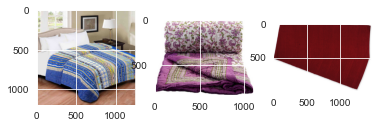

Baby Care
-------
For this category, we have 150 images.


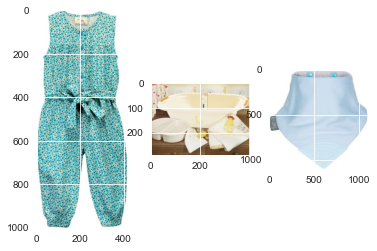

Watches
-------
For this category, we have 150 images.


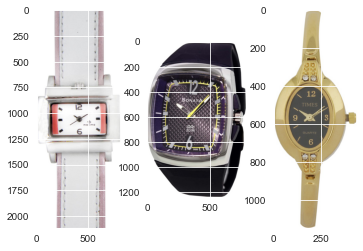

Home Decor & Festive Needs
-------
For this category, we have 150 images.


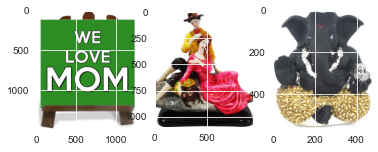

Kitchen & Dining
-------
For this category, we have 150 images.


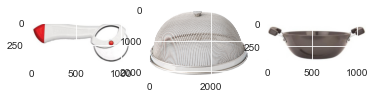

Beauty and Personal Care
-------
For this category, we have 150 images.


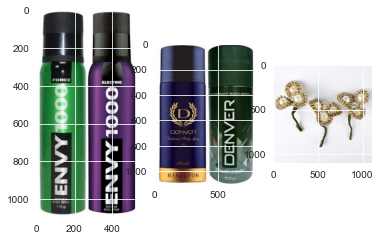

Computers
-------
For this category, we have 150 images.


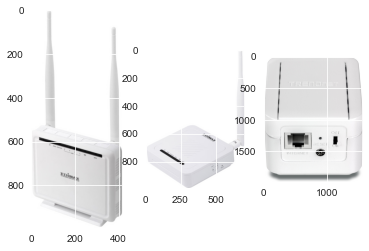

In [8]:
n_categories = len(list_labels)
n_photos = len(list_photos)

display_images_per_category(list_labels, data_images, path_images, "image_path", "category", list_photos)

In [9]:
data_images.target

0       4
1       0
2       0
3       4
4       4
       ..
1045    0
1046    0
1047    0
1048    0
1049    0
Name: target, Length: 1050, dtype: int64

# PART 2 : CNN and Transfert Learning

## 1) CNN

In [135]:
filename = path_images + list_photos[0]
img = Image.open(filename)

# Afficher l'image chargée
img.show()

In [12]:
filename

'./dataset/images/009099b1f6e1e8f893ec29a7023153c4.jpg'

In [13]:
data_images[data_images["image_path"] == list_photos[0]]

,image_path,category,target
280,009099b1f6e1e8f893ec29a7023153c4.jpg,Watches,6


#### Functions

In [136]:
def map_category(y, dict_categories):
    """
    y is a proba vector of length 7
    :param y:
    :return:
    """
    return dict_categories[y.argmax()]

In [188]:
def prepare_image_as_input(img_filename, img_dir):
    """"
    preprocess the image for VGG
    """
    # get the image path
    img_path = img_dir + img_filename

    # load an image from file
    img = load_img(img_path, target_size=(224, 224))
    # convert the image pixels to a numpy array
    img = img_to_array(img)
    # reshape data for the model # Créer la collection d'images (un seul échantillon)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    # prepare the image for the VGG model # Prétraiter l'image comme le veut VGG-16
    img = preprocess_input(img)
    return img

In [138]:
def predict_features(img_filename, img_dir, model):
    """
    y is a proba vector of length 7
    :param y:
    :return:
    """
    # get the image path
    img = prepare_image_as_input(img_filename, img_dir)
    # predict
    features = model.predict(img)
    return features

In [139]:
def predict_category(img_filename, img_dir, model, dict_categories):
    """
    y is a proba vector of length 7
    :param y:
    :return:
    """
    img = prepare_image_as_input(img_filename, img_dir)

    # predict
    y = model.predict(img)
    #print(y)
    #print("y argmax", y.argmax())
    # get category
    category_nb = y.argmax()
    category = dict_categories[category_nb]
    return category_nb, category

In [148]:
mapper = data_images[["category", "target"]].drop_duplicates().sort_values(by="target").reset_index(drop=True)
mapper

,category,target
0,Baby Care,0
1,Beauty and Personal Care,1
2,Computers,2
3,Home Decor & Festive Needs,3
4,Home Furnishing,4
5,Kitchen & Dining,5
6,Watches,6


In [149]:
mapping_categories = {row["target"]: row["category"] for i, row in mapper.iterrows() }
mapping_categories

{0: 'Baby Care',
 1: 'Beauty and Personal Care',
 2: 'Computers',
 3: 'Home Decor & Festive Needs',
 4: 'Home Furnishing',
 5: 'Kitchen & Dining',
 6: 'Watches'}

#### End of functions

In [150]:
model = VGG16() # Création du modèle VGG-16 implementé par Keras

In [152]:
img = prepare_image_as_input(list_photos[0], path_images)

In [153]:
y = model.predict(img)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

In [154]:
y

array([[4.22403339e-08, 5.39009442e-08, 3.37463746e-08, 2.61429154e-08,
        5.28884634e-08, 1.10302267e-06, 2.86566788e-08, 8.05155480e-08,
        3.19080215e-07, 2.40991902e-08, 2.26166634e-07, 1.97779158e-07,
        1.25265456e-06, 2.68786579e-07, 3.41481427e-06, 3.70410731e-07,
        5.47344939e-07, 3.35126401e-06, 1.68759811e-06, 7.42608563e-07,
        6.60823432e-08, 3.43390695e-07, 1.71946951e-07, 3.55883856e-08,
        4.42242435e-06, 1.64984868e-07, 1.00601838e-07, 2.61423793e-07,
        4.83727206e-07, 1.73879169e-08, 4.78276377e-07, 1.84430633e-07,
        5.82956375e-07, 1.74802523e-07, 1.08842471e-06, 7.86367593e-08,
        9.11047437e-07, 6.26091662e-07, 5.71283124e-07, 9.26302448e-08,
        2.63617181e-07, 3.40260215e-07, 6.25913174e-07, 7.37802054e-07,
        4.22364877e-07, 3.51332858e-07, 4.89278534e-07, 4.88601745e-06,
        2.84077579e-08, 9.61421662e-08, 7.05102465e-08, 5.83458586e-07,
        1.08199829e-05, 2.43534614e-05, 1.61413427e-05, 2.597707

In [155]:
# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions(y, top=5)[0])

Top 3 : [('n03706229', 'magnetic_compass', 0.40458965), ('n02708093', 'analog_clock', 0.21896486), ('n03314780', 'face_powder', 0.05964659), ('n04548280', 'wall_clock', 0.043594617), ('n04328186', 'stopwatch', 0.040686537)]


## 2) Transfert Learning / 0.4 et 0.6

##### 1) Classification ?

In [156]:
# load model
#model = VGG16()
# remove the output layer
#model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

vgg = VGG16()
vgg.layers.pop()
vgg.layers.pop()

vgg_transfer = Sequential()
vgg_transfer.add(vgg)
vgg_transfer.trainable = False
vgg_transfer.add(Dense(n_categories, activation='softmax'))
#vgg_transfer.compile(loss='mean_squared_error', optimizer='sgd')
vgg_transfer.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [157]:
vgg_transfer.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense_6 (Dense)             (None, 7)                 7007      
                                                                 
Total params: 138,364,551
Trainable params: 0
Non-trainable params: 138,364,551
_________________________________________________________________


In [158]:
test_cnn = data_images.copy()
test_cnn["prediction_category"] = -1

In [159]:
#test_cnn.at[0, "prediction_category"] = 2
test_cnn

,image_path,category,target,prediction_category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4,-1
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0,-1
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0,-1
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4,-1
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4,-1
...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0,-1
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0,-1
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0,-1
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0,-1


In [176]:
result = predict_category(list_photos[1], path_images, vgg_transfer, mapping_categories)

In [177]:
result

(1, 'Beauty and Personal Care')

In [165]:
for index, row in tqdm(test_cnn.iterrows(), total=test_cnn.shape[0]):
    #print("Step :", index)
    img = test_cnn.at[index, "image_path"]
    #print(img)
    result = predict_category(img, path_images, vgg_transfer, mapping_categories)
    test_cnn.at[index, "prediction_category"] = result[0]


100%|██████████| 1050/1050 [09:46<00:00,  1.79it/s]


In [173]:
test_cnn

,image_path,category,target,prediction_category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4,5
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0,4
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0,4
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4,5
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4,5
...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0,5
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0,5
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0,4
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0,4


In [168]:
test_cnn.to_csv("dataset/test_cnn.csv")

In [169]:
conf_mat = metrics.confusion_matrix(y_true=test_cnn["target"], y_pred=test_cnn["prediction_category"])
print(conf_mat)

[[35 29  9 24 30 14  9]
 [35 17  5  7 10 15 61]
 [ 3 11 26 16 23  4 67]
 [19 13  8 32 26 20 32]
 [18 18  7 21 31 48  7]
 [ 6 76 10 28 22  5  3]
 [25 11  4 27 47  3 33]]


In [170]:
list_labels

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [185]:
for label in mapping_categories:
    print(mapping_categories[label])

Baby Care
Beauty and Personal Care
Computers
Home Decor & Festive Needs
Home Furnishing
Kitchen & Dining
Watches


<AxesSubplot:>

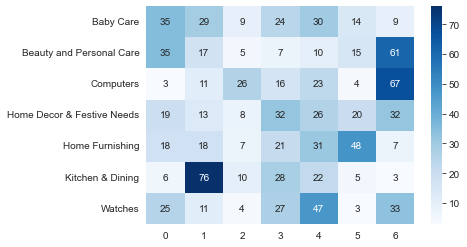

In [186]:
df_cm = pd.DataFrame(conf_mat, index=[mapping_categories[label] for label in mapping_categories.keys()],
                     columns=[str(label) for label in mapping_categories])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

In [187]:
print("ARI : ", metrics.adjusted_rand_score(test_cnn["target"], test_cnn["prediction_category"]))

ARI :  0.07536772332244963


##### 2) tuto : Feature Extractor Preprocessor

In [87]:
# example of using the vgg16 model as a feature extraction model

from pickle import dump


In [189]:
image = prepare_image_as_input(list_photos[0], path_images)

In [190]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [191]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [192]:
# get extracted features
features = model.predict(image)
print(features.shape)
# save to file
#dump(features, open('dog.pkl', 'wb'))

(1, 4096)


In [193]:
features

array([[2.5928054 , 2.6987507 , 0.        , ..., 0.87792766, 0.        ,
        2.9672122 ]], dtype=float32)

##### Making features for all the images

In [194]:
df = data_images.copy()
df["features"] = -1
df["features_PCA"] = -1
df

,image_path,category,target,features,features_PCA
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4,-1,-1
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0,-1,-1
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0,-1,-1
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4,-1,-1
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4,-1,-1
...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0,-1,-1
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0,-1,-1
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0,-1,-1
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0,-1,-1


 85%|████████▍ | 890/1050 [07:35<01:57,  1.37it/s]

In [196]:
vgg_features = []

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    img_filename = df.at[index, "image_path"]
    features = predict_features(img_filename, path_images, model)
    vgg_features.append(features)
    #df.at[index, "features"] = np.array(features)

100%|██████████| 1050/1050 [09:03<00:00,  1.93it/s]


In [198]:
len(vgg_features)

1050

In [200]:
vgg_features_by_img = np.asarray(vgg_features)
vgg_features_all = np.concatenate(vgg_features_by_img, axis=0)

In [201]:
np.savez_compressed('dataset/vgg_features_by_img.npz', vgg_features_by_img)
np.savez_compressed('dataset/vgg_features_all.npz', vgg_features_all)

In [203]:
dict_data = np.load('dataset/vgg_features_all.npz')
vgg_features_all = dict_data['arr_0']

dict_data = np.load('dataset/vgg_features_by_img.npz', allow_pickle=True)
vgg_features_by_img = dict_data['arr_0']

In [205]:
vgg_features_all


array([[3.3986163 , 0.8595742 , 0.        , ..., 0.        , 0.85105604,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.2971013 , 0.        ,
        0.        ],
       ...,
       [2.1961308 , 2.3982728 , 2.6236415 , ..., 2.1598763 , 0.1847224 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.24832901,
        0.9251385 ],
       [0.        , 0.        , 0.12313145, ..., 0.        , 0.527719  ,
        2.9917479 ]], dtype=float32)

In [206]:
print("Dimensions dataset avant réduction PCA : ", vgg_features_all.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(vgg_features_all)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 803)


In [207]:
tsne = manifold.TSNE(n_components=2, perplexity=30,
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data_images["category"]
print(df_tsne.shape)


(1050, 3)


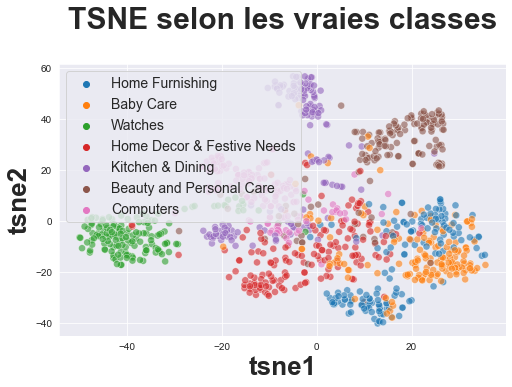

In [208]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief", s=50, alpha=0.6) # palette=sns.color_palette('tab10', n_colors=4),

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()


##### Clustering

In [210]:
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 4)


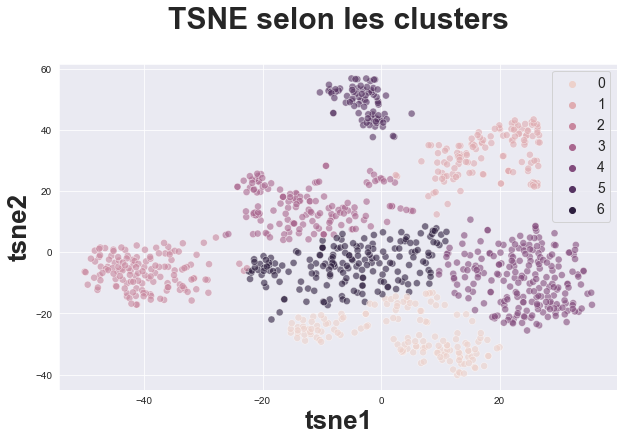

ARI :  0.43704116518559605


In [211]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster", s=50, alpha=0.6,
    data=df_tsne,
    legend="brief") # palette=sns.color_palette('tab10', n_colors=4),

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

labels = data_images["target"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

#### 1) Stratégie : fine-tuning total

In [15]:
for layer in model.layers:
    layer.trainable = True

#### 2) Stratégie : extraction des features

In [16]:
for layer in model.layers:
    layer.trainable = False

#### 3) Stratégie : fine-tuning partiel

In [17]:
# Ne pas entraîner les 5 premières couches (les plus basses)
for layer in model.layers[:5]:
    layer.trainable = False

#### Conclusion TL : compile puis fit !

In [18]:
# Compiler le modèle
new_model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

# Entraîner sur les données d'entraînement (X_train, y_train)
model_info = new_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)


NameError: name 'new_model' is not defined

In [ ]:
# End of notebook time
t1 = time()
print("computing time : {:8.6f} sec".format(t1 - t0))
print("computing time : " + strftime('%H:%M:%S', gmtime(t1 - t0)))